# 03-Jan-2015: Text Mining of SMS for Banco Familiar

## Ref: http://radimrehurek.com/data_science_python/

In [389]:
%pylab inline
## This imports numpy and matplotlib functions

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['colors', 'legend']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


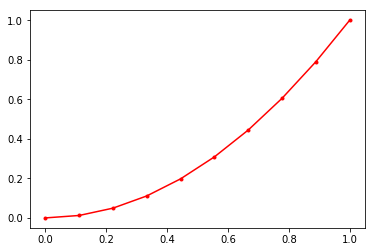

In [390]:
x = linspace(0, 1, 10)
y = x**2
plot(x,y,'r.-')

## Importing modules

In [494]:
import unicodedata
import re
import numpy as np
import scipy as sp
import scipy.sparse.linalg as slinalg
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pickle
import pandas as pd
import sklearn as sk
import sklearn.cluster as cluster
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [392]:
projdir = "E:/Daniel/Projects/Hackatons/201806-HackNLead-Zurich/swisscom/"
datadir = projdir + "data/"
resultsdir = projdir + "results/Daniel/DescriptionBasedClustering/"

## Define functions

In [393]:
def analyzeMessage(message, corpus, terms, dtfmatrix, tfidfmatrix):
    """Show the frequency and TF-IDF weight of the terms (words or n-grams) appearing in a message of a corpus,
    based on the text analysis performed on the corpus.
    
    Parameters:
    message: string
        Message to analyze. It must be part of the corpus.
        
    corpus: data frame
        Set of messages used for the text analysis.
        
    terms: list
        List of terms identified by the text analyzer in the corpus
        
    dtfmatrix: matrix (generally sparse)
        Document term frequency matrix indicating how many times appears each term in a document of the corpus.
        This matrix is typically generated by CountVectorizer().fit_transform().
        
    tfidfmatrix: matrix (generally sparse)
        Document term frequency matrix weighted by the Inverse Document Frequency of each term.
        This matrix is typically generated by TfidfTransfomer().fit().
    """
    #----------------- Extract the information about the message
    # Find the message number in the corpus (choose the first index in case the message appears several times --> this is what [0][0] does)
    # Note that I cannot use corpus.index[corpus==message] because this returns the index LABELS (e.g. 0, 4, 7, etc.) which is NOT
    # how the matrices are indexed.
    indmessage = np.where(corpus==message)
    if len(indmessage[0]) == 0:
        print("Message not found")
    else:
        indmessage = indmessage[0][0]
        print(indmessage)
        # Retrieve the Document-Term frequency values for the analyzed message (it is a matrix of a single row)
        message_bow = dtfmatrix[indmessage]
        # Compute the TF-IDF weight for each term in the message using the Document-Term frequency matrix stored in countVectorizerFit.
        message_tfidf = tfidfmatrix[indmessage]
        # Get the terms appearing in the message for displaying purposes
        indterms = np.asarray(np.where(message_tfidf.todense()>0)[1])  #[0] (add this if without it, it doesn't work)
        terms = np.array(terms)[indterms]
        # Convert message_bow and message_tfidf to lists in order to iterate over them
        message_bow = np.asarray(message_bow.todense()[message_bow.todense()>0])[0].tolist()
        message_tfidf = np.asarray(message_tfidf.todense()[message_tfidf.todense()>0])[0].tolist()

        #----------------- Construct a data frame for display
        toshow = pd.DataFrame.from_items([('indterm', indterms), ('term', terms), ('TF', message_bow), ('TFIDF', message_tfidf)])

        #----------------- Show message and its TF-IDF values
        print("Message:")
        print(message)
        print("Terms frequency in message:")
        print(toshow)

In [459]:
def plotFrequencies(terms, freq, color, title="Term frequencies", fontsize=12, figsize=(30,5), savefile=None, saveformat="jpg"):
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    xlab = terms.tolist()
    xval = np.arange(len(terms))
    yval = freq

    width = 0.7
    plt.barh(xval, yval, width)
    #bar(xval, yval, width, orientation='horizontal')
    plt.title(title)

    ax.set_yticks(xval + 0.5*width)
    ax.invert_yaxis()
    ytickNames = ax.set_yticklabels(xlab)
    plt.setp(ytickNames, rotation=0, fontsize=fontsize)
    if savefile:
        plt.savefig(savefile, format=saveformat, bbox_inches='tight', pad_inches=0.1) 
            ## bbox_inches and pad_inches options are there to avoid cropping the labels and titles in the plot

In [395]:
def showBiplot(documents, terms, corpus, allterms, tfidfmatrix, eigenleft, eigenvalues, eigenright, scale=1, pcs=[1,2]):
    """ Generate a biplot of documents and terms
    documents: list
        List of messages to plot.
        
    terms: list
        List of terms to plot.
        
    corpus: array
        Array of messages in the corpus.
        
    allterms: list
        List of all terms found by the CountVectorizer class.

    tfidfmatrix: matrix
        Document-Term frequency matrix containing the messages coordinates on the original axes.
        
    eigenleft: numpy array
        Left eigenvector matrix of the SVD of tfidfmatrix.
        
    eigenvalues: numpy array
        Singular values of the SVD of tfidfmatrix.
        
    scale: float
        Value between [0, 1] giving the scale to apply to the eigenvalues.
        The documents (data) are scaled by eigenvalue^(1-scale) (i.e. typically they have no scaling)
        The terms (variables) are scaled by eigenvalue^scale (i.e. typically they are multiplied by the eigenvalue so that they
        original vector e.g. (1,0,0,0,0,0, ...) is expanded when projected on the corresponding eigenvector and is not seen so small.
        Default: 1
        
    pcs: list
        List of the 2 PC numbers to plot
        Default: [1,2]
    """
    
    #-------------- Parse input parameters
    print("Messages to plot:")
    print(documents)
    print("Terms to plot:")
    print(terms)
    
    # Eigenvectors
    U = eigenleft
    Vt = eigenright  # already transposed

    # Find the message numbers in the corpus
    indmessages = []
    for m in documents:
        try:
            indmessages.append( np.where(corpus==m)[0][0] )   # Choose the first index in case the message appears several times ([0][0])
        except:
            print("WARNING: Message", m, "not found.")
    print("indmessages:")
    print(indmessages)
    
    # Find the term indices to plot. These indices define the rows of U that correspond to each term.
    indterms = []
    for t in terms:
        try:
            indterms.append( allterms.index(t) )
        except:
            print("WARNING: Term", t, "not found.")

    # Subset the TF-IDF matrix to the messages to plot. Recall that TF-IDF is a Document x Term matrix
    # M has one column per document and one row per term
    MD = tfidfmatrix[indmessages,:].T
    print("Shape of the TF-IDF matrix restricted to the documents to analyze")
    print(MD.shape)

    # Subset the TF-IDF matrix to the terms to plot. Recall that TF-IDF is a Document x Term matrix
    # M has one column per document and one row per term
    MT = tfidfmatrix[:,indterms].T
    print("Shape of the TF-IDF matrix restricted to the terms to analyze")
    print(MT.shape)
   
    # Compute the coordinates of the messages in ALL the PC coordinates defined by the columns of U (eigenvectors)
    # D = data
    D = U.T * MD # Size: #PCs x #messages
    print("Shape of the projected Document matrix")
    print(D.shape)

    # Compute the coordinates of the terms in ALL the PC coordinates. These are the rows of U indexed by indterms.
    # Ref: http://en.wikipedia.org/wiki/Biplot
    T = Vt * MT.T  # Size: #PCs x #terms
    print("Shape of the Term matrix")
    print(T.shape)
    
    # Define PCs to plot as row indices of the D and T matrices
    # (suffix p means "plot")
    # NOTE THAT SINGULAR VALUES IN THE OUTPUT OF scipy.sparse.linalg.svds() ARE ORDERED FROM SMALLER TO LARGER!!
    neigen = len(eigenvalues)
    xpc, ypc = neigen - pcs[0], neigen - pcs[1]
    #xpc, ypc = 1, 2
    nmessages = D.shape[1]
    nterms = T.shape[1]
    
    #------------------------------- Plot
    plt.figure()
    factor_points = 1.1   # Factor used to separate labels from plotted points or arrows
    factor_arrows = 1.3   # Factor used to separate labels from plotted points or arrows
    print("Plotting biplot on PCs", neigen - xpc, "and", neigen - ypc)
    # Plot terms (variables) as points
    x = T[xpc,:]*eigenvalues[xpc]**(1-scale)
    y = T[ypc,:]*eigenvalues[ypc]**(1-scale)
    plt.scatter(x, y, c='b', marker='.')
    for j in range(nterms):
        print("Point", j, ":", (x[j],y[j]))
        plt.text(x[j]*factor_points, y[j]*factor_points, terms[j], color='b', ha='center', va='center')

    # Plot documents (data) as arrows
    for j in range(nmessages):
        print("Document j =", j)
        x, y = D[xpc,j]*eigenvalues[xpc]**scale, D[ypc,j]*eigenvalues[ypc]**scale
        print("Arrow", j, ":", (x,y))
        plt.arrow(0, 0, x, y, color='k', width=0.0001, head_width=0.00)
        plt.text(x*factor_arrows, y*factor_arrows, documents.iloc[j][0:10], color='k', ha='center', va='center')

    #plt.xlabel('PC{}'.format(xpc + 1))
    #plt.ylabel('PC{}'.format(ypc + 1))

    plt.show()

In [396]:
# DM-2015/01/23: This is my call: need itertools for the chain() function used by ngrams().
import itertools as it

def ngrams(sequence, n, pad_left=False, pad_right=False, pad_symbol=None):
    """Function taken from:
    http://stackoverflow.com/questions/2380394/simple-implementation-of-n-gram-tf-idf-and-cosine-similarity-in-python
    on 23-Jan-2015
    
    A utility that produces a sequence of ngrams from a sequence of items.
    For example:

    >>> ngrams([1,2,3,4,5], 3)
    [(1, 2, 3), (2, 3, 4), (3, 4, 5)]

    Use ingram for an iterator version of this function.  Set pad_left
    or pad_right to true in order to get additional ngrams:

    >>> ngrams([1,2,3,4,5], 2, pad_right=True)
    [(1, 2), (2, 3), (3, 4), (4, 5), (5, None)]

    @param sequence: the source data to be converted into ngrams
    @type sequence: C{sequence} or C{iterator}
    @param n: the degree of the ngrams
    @type n: C{int}
    @param pad_left: whether the ngrams should be left-padded
    @type pad_left: C{boolean}
    @param pad_right: whether the ngrams should be right-padded
    @type pad_right: C{boolean}
    @param pad_symbol: the symbol to use for padding (default is None)
    @type pad_symbol: C{any}
    @return: The ngrams
    @rtype: C{list} of C{tuple}s
    """

    if pad_left:
        sequence = it.chain((pad_symbol,) * (n-1), sequence)
    if pad_right:
        sequence = it.chain(sequence, (pad_symbol,) * (n-1))
    sequence = list(sequence)

    count = max(0, len(sequence) - n + 1)
    return [tuple(sequence[i:i+n]) for i in range(count)] 

In [397]:
# Example
ngrams(('manana', 'voy', 'a', 'pagar'), 2)

[('manana', 'voy'), ('voy', 'a'), ('a', 'pagar')]

## 0.- Read messages

In [398]:
df = pd.read_csv(datadir + "startup.ch 2013 - 2018.csv", encoding="iso-8859-1")

In [399]:
df

,Salutation,Firstname,Lastname,Company,City,Uni spin-off,Technology,Incorporation Date,Number of Employees,1Liner,Description
0,Cher Monsieur,Osiris,Marroquin,ImmunOs Therapeutics GmbH,Basel,Swiss Federal Institute of Technology Lausanne...,Biotech,09/12/2014 00:00,NaN,Drug development using a novel method to antag...,ImmunOs Therapeutics AG is leading the next ge...
1,Dear Dr.,Srinivasan,Murali,SmartCardia SA,Lausanne,Swiss Federal Institute of Technology Lausanne...,"Micro-, Nano Technology",29/10/2013 00:00,NaN,Cloud based cardiac solution,We have developed an ultra-small portable card...
2,Dear,Mark-Eric,Jones,Leman Micro Devices SA,Lausanne,Andere - Autres - Others,"Micro-, Nano Technology",29/01/2013 00:00,NaN,Bringing the latest digital technology to the ...,A personal health monitor in your smartphone: ...
3,Sehr geehrter Herr,Bertrand,Baeriswyl,FairTrace SA,Sierre,Andere - Autres - Others,Software,01/10/2013 00:00,2.0,"Allowing the user to know the origin, the cycl...",The Company\r\n\r\nFairTrace is a Swiss compan...
4,Dear Mr.,Rajwinder,Lehal,Cellestia Biotech AG,Basel,Swiss Federal Institute of Technology Lausanne...,Biotech,20/05/2014 00:00,7.0,Targeted anti-cancer therapy,Cellestia focuses on small molecules capable o...
5,Sehr geehrter Herr Dr.,Nicola,Tomatis,BlueBotics SA,St-Sulpice,Andere - Autres - Others,"Electronics, Mechanics",04/04/2014 00:00,NaN,Autonomous navigation to enable the mobility o...,The company is a spin-off company of the Auton...
6,Lieber,Thomas,Ulrich,Allthings Technologies AG,Basel,University of St. Gallen (HSG),Software,17/01/2013 00:00,60.0,Micro-applications for all things precious,Allthings transforms buildings into digital pr...
7,Liebe,Jean-Pierre,Obrecht,Polyphor AG,Allschwil,NaN,Biotech,02/09/2013 00:00,NaN,"Novel antibiotics, oncology treatments and res...","Polyphor is a clinical stage, privately held S..."
8,Lieber,Jean-Jacques,Becciolini,TECURO AG,Luzern,Swiss Federal Institute of Technology Zurich (...,Medtech,19/06/2013 00:00,5.0,Mission is the promotion of new solutions for ...,Tecuro has developed a novel medical device cl...
9,Sehr geehrter Herr,Christoph,Schumacher,Novamem AG,Zürich,NaN,"Materials, Chemicals",28/02/2013 00:00,NaN,Providing bioseparation membranes and chemical...,Our membranes and dialysis systems help you pu...


In [400]:
df.columns

Index(['Salutation', 'Firstname', 'Lastname', 'Company', 'City',
       'Uni spin-off', 'Technology', 'Incorporation Date',
       'Number of Employees', '1Liner', 'Description'],
      dtype='object')

## 1.- Prepare data

In [401]:
# Remove trailing blanks
#df.columns = [c.rstrip() for c in df.columns]

In [402]:
df.columns

Index(['Salutation', 'Firstname', 'Lastname', 'Company', 'City',
       'Uni spin-off', 'Technology', 'Incorporation Date',
       'Number of Employees', '1Liner', 'Description'],
      dtype='object')

In [403]:
# Remove trailing blanks
messages = df['Description']
print(messages.head())
#messages = [m.rstrip() for m in df['Description']]
#messages[:14]
#[m for m in messages]

0    ImmunOs Therapeutics AG is leading the next ge...
1    We have developed an ultra-small portable card...
2    A personal health monitor in your smartphone: ...
3    The Company\r\n\r\nFairTrace is a Swiss compan...
4    Cellestia focuses on small molecules capable o...
Name: Description, dtype: object


In [404]:
# Define function to replace strange characters (e.g. Ú with é, etc.)
import warnings
import re
def charReplace(oldchars, newchars, message):
    oldlen = len(oldchars)
    newlen = len(newchars)
    if oldlen != newlen:
        warnings.warn ( "Input parameters oldchars and newchars do not have the same length."
                        "The first oldchars will be replaced with the first newchars."
                        "If oldchars is longer than newchars, the last oldchars chars will be removed."
                        "If newchars is longer than newchars, the last oldchars chars will be ignored.")
    for l in range(len(oldchars)):
        old = oldchars[l]
        if l >= newlen:
            new = ""
        else:
            new = newchars[l]
        try: # The re.sub() conversion fails if the message is not of type str
            message = re.sub(old, new, message)
        except:
            pass
        
    return message

In [405]:
# Replace NaN with empty string
messages = list(map(lambda m: "" if type(m) == np.float else m, messages))
#messages = [str(m) for m in messages]

In [406]:
# Test unicode normalization. Possible norms are NFC, NFKC, NFD, NFKD (i.e. Normal Form C, Normal Form KC, etc.)
# Fore more info, see the unicodedata documentation: https://docs.python.org/2/library/unicodedata.html
print(messages[3])
unicodedata.normalize('NFD', messages[3])

The Company

FairTrace is a Swiss company established in 2013 in Sierre at Techno-Pôle. It was born following a common project between the University of Applied Sciences in Valais and Importexa, a company specialized in the development and manufacture of professional clothing.


Challenge

With a view for valorisation of their products or responsibility in incidents related to poor knowledge of the production chain (chemical products, social conditions of workers ...), companies are seeking a way to make their products transparent and / or compliant with European standards (REACH ...) or various labels.

On their side, increasingly sensitive to sustainable and equitable dimension of their purchases, consumers now want to buy products made responsibly. They want information related to the origin and method of production.


Solution  FairTrace Traceability Tool

To meet these needs, FairTrace developed FairTrace Traceability Tool. This is an effective, innovative and patented computer s

'The Company\r\n\r\nFairTrace is a Swiss company established in 2013 in Sierre at Techno-Pôle. It was born following a common project between the University of Applied Sciences in Valais and Importexa, a company specialized in the development and manufacture of professional clothing.\r\n\r\n\r\nChallenge\r\n\r\nWith a view for valorisation of their products or responsibility in incidents related to poor knowledge of the production chain (chemical products, social conditions of workers ...), companies are seeking a way to make their products transparent and / or compliant with European standards (REACH ...) or various labels.\r\n\r\nOn their side, increasingly sensitive to sustainable and equitable dimension of their purchases, consumers now want to buy products made responsibly. They want information related to the origin and method of production.\r\n\r\n\r\nSolution \x96 FairTrace Traceability Tool\r\n\r\nTo meet these needs, FairTrace developed FairTrace Traceability Tool. This is a

In [407]:
#oldchars = u'¨Ú'
#newchars = 'ue'
oldchars = "\r\n`àáâäèéêëìíîïòóôöùúûü"
newchars = "  `aaaaeeeeiiiioooouuuu"
charReplace(oldchars, newchars, messages[4])

'Cellestia focuses on small molecules capable of modulating a key cellular pathway controlling oncogenesis and cancer stem cells called Notch.    VISION    Cellestia is actively engaged in clinical development of first-in-class targeted therapeutics with untapped mode of action, to address unmet medical need in patients with oncology and immunological disorders.    MISSION    Develop CB-103, a novel, first-in-class, oral pan-NOTCH inhibitor with a unique mode of action for treatment of NOTCH dependent leukemias, lymphomas and solid tumors.    HISTORY    Cellestia Biotech AG was founded in 2014 as a spin-off from EPFL (Ecole Polytechnique Federale de Lausanne, Switzerland). Cellestia`s pipeline including lead candidate, oral small molecule CB-103 is based on proprietary know-how and more than two decades of research in Prof. Radtke´s laboratory at Swiss Institute for Experimental Cancer Research (ISREC) at EPFL. Prof. Freddy Radtke is an internationally recognized key opinion leader in 

In [408]:
messages = [charReplace(oldchars, newchars, m) for m in messages]
messages[:5]

['ImmunOs Therapeutics AG is leading the next generation of immunotherapies by fast-tracking new discoveries to enhance combination therapies with novel human immunomodulatory proteins that have a role in both the innate and adaptive immune system for cancer treatment.  ',
 "We have developed an ultra-small portable cardiac monitoring device and software that is a leap forward compared to today's bulky patient worn ECG monitors. The device continuously records and transmits the ECG data to a smart phone and from there to a hospital center or directly to the doctor. We have developed complex algorithms that can automatically detect dangers in the heart beat, such as the different arrhythmia events. These algorithms are directly embedded on a smart wearable ECG monitoring device and can automatically trigger a warning to the doctor/hospital in case of such events.",
 "A personal health monitor in your smartphone: Measure your blood pressure and other vital signs, and , with your consent,

In [409]:
# Replace accented letters with non-accented ones
# For an interesting example of unicodedata.normalize using the 4 different norms (NFC, NFKC, NFD, NFKD) see:
# http://stackoverflow.com/questions/12944678/using-unicodedata-normalize-in-python-2-7
messages = [unicodedata.normalize('NFD', m).encode('ascii', 'ignore') for m in messages]

In [410]:
print(len(messages))

667


In [411]:
for message_nro, message in enumerate(messages[:2]):
    print(message_nro, message)

0 b'ImmunOs Therapeutics AG is leading the next generation of immunotherapies by fast-tracking new discoveries to enhance combination therapies with novel human immunomodulatory proteins that have a role in both the innate and adaptive immune system for cancer treatment.  '
1 b"We have developed an ultra-small portable cardiac monitoring device and software that is a leap forward compared to today's bulky patient worn ECG monitors. The device continuously records and transmits the ECG data to a smart phone and from there to a hospital center or directly to the doctor. We have developed complex algorithms that can automatically detect dangers in the heart beat, such as the different arrhythmia events. These algorithms are directly embedded on a smart wearable ECG monitoring device and can automatically trigger a warning to the doctor/hospital in case of such events."


In [412]:
# Create a data frame from the messages list and their lengths
messages = pd.DataFrame.from_items([('msg', messages), ('len', list(map(len, messages)))])

In [413]:
messages.head()

,msg,len
0,b'ImmunOs Therapeutics AG is leading the next ...,269
1,"b""We have developed an ultra-small portable ca...",598
2,"b""A personal health monitor in your smartphone...",723
3,b'The Company FairTrace is a Swiss company ...,1962
4,b'Cellestia focuses on small molecules capable...,1189


In [414]:
messages.len.describe()

count     667.000000
mean      616.392804
std       526.412995
min         0.000000
25%       300.000000
50%       489.000000
75%       751.500000
max      5098.000000
Name: len, dtype: float64

(array([354., 237.,  39.,  18.,  10.,   6.,   1.,   1.,   0.,   1.]),
 array([   0. ,  509.8, 1019.6, 1529.4, 2039.2, 2549. , 3058.8, 3568.6,
        4078.4, 4588.2, 5098. ]),
 <a list of 10 Patch objects>)

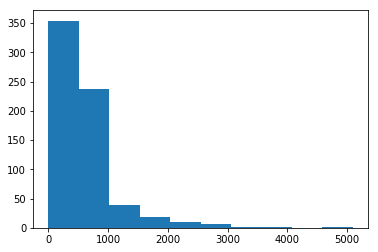

In [415]:
# Distribution of message lengths
plt.hist(messages.len)

In [416]:
# Remove messages with zero length
len(messages[messages.len==0])

10

In [417]:
messages = messages[messages.len>0]
len(messages)

657

(array([369., 217.,  36.,  16.,  10.,   6.,   1.,   1.,   0.,   1.]),
 array([  46. ,  551.2, 1056.4, 1561.6, 2066.8, 2572. , 3077.2, 3582.4,
        4087.6, 4592.8, 5098. ]),
 <a list of 10 Patch objects>)

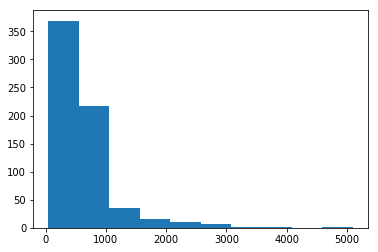

In [418]:
# Updated distribution
plt.hist(messages.len)

In [419]:
# Compute the number of words in messages and their lengths by first removing punctuation marks
# Note that punctuation marks are eliminated by CountVectorizer() by default.
punct = "[.:,;()\[\]\\\/\?\!]"
re.subn(punct, "", "test... \/[ :ok what else (:) a...?!")

('test  ok what else  a', 15)

In [420]:
#messages['msg0'] = [re.sub(punct, "", m) for m in messages.msg]

In [421]:
messages.head()

,msg,len
0,b'ImmunOs Therapeutics AG is leading the next ...,269
1,"b""We have developed an ultra-small portable ca...",598
2,"b""A personal health monitor in your smartphone...",723
3,b'The Company FairTrace is a Swiss company ...,1962
4,b'Cellestia focuses on small molecules capable...,1189


In [422]:
# Count the words in each message and the ratio of len / words (which is also the average word length)
messages['nwords'] = [len(words) for words in [m.split() for m in messages.msg]]
messages['wordlen'] = messages.apply(lambda row: row['len'] / row['nwords'] if row['nwords'] > 0 else 0, axis=1)
messages

,msg,len,nwords,wordlen
0,b'ImmunOs Therapeutics AG is leading the next ...,269,38,7.078947
1,"b""We have developed an ultra-small portable ca...",598,95,6.294737
2,"b""A personal health monitor in your smartphone...",723,110,6.572727
3,b'The Company FairTrace is a Swiss company ...,1962,289,6.788927
4,b'Cellestia focuses on small molecules capable...,1189,168,7.077381
5,b'The company is a spin-off company of the Aut...,244,38,6.421053
6,b'Allthings transforms buildings into digital ...,912,136,6.705882
7,"b""Polyphor is a clinical stage, privately held...",893,130,6.869231
8,b'Tecuro has developed a novel medical device ...,1553,231,6.722944
9,b'Our membranes and dialysis systems help you ...,652,92,7.086957


(array([ 2.,  3., 11.,  8., 31., 37., 43., 52., 71., 71., 71., 57., 56.,
        30., 33., 24., 24., 10.,  9.,  4.,  3.,  4.,  1.,  1.,  1.]),
 array([5.33823529, 5.48083491, 5.62343454, 5.76603416, 5.90863378,
        6.0512334 , 6.19383302, 6.33643264, 6.47903226, 6.62163188,
        6.7642315 , 6.90683112, 7.04943074, 7.19203036, 7.33462998,
        7.4772296 , 7.61982922, 7.76242884, 7.90502846, 8.04762808,
        8.1902277 , 8.33282732, 8.47542694, 8.61802657, 8.76062619,
        8.90322581]),
 <a list of 25 Patch objects>)

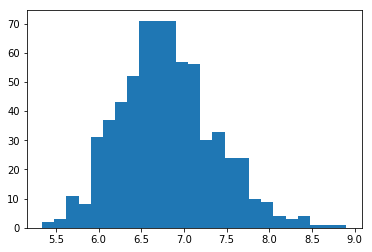

In [423]:
# Distribution of average word length
plt.hist(messages.wordlen, bins=25)

In [424]:
# Look at the messages with Length / nwords ratio > 20
#messages.msg[messages.wordlen>20]

In [425]:
# Compute the median word length (ratio length / nwords) so that I can decide on a threshold
wordlen_median = np.median(messages.wordlen)
print(wordlen_median)

6.762589928057554


In [426]:
messages.wordlen.describe(percentiles=np.linspace(0,1,10))

count    657.000000
mean       6.800152
std        0.565210
min        5.338235
0%         5.338235
11.1%      6.119363
22.2%      6.369591
33.3%      6.550239
44.4%      6.683095
50%        6.762590
55.6%      6.837507
66.7%      6.991127
77.8%      7.188258
88.9%      7.518120
100%       8.903226
max        8.903226
Name: wordlen, dtype: float64

In [427]:
# Create all lower-case messages in unicode UTF-8 because this is the input for CountVectorizer
# which is used to create the sparse matrix of word counts by message.
messages['msgu'] = [str(m.lower(), 'utf-8') for m in messages.msg]
print(len(messages))
messages.head()

657


,msg,len,nwords,wordlen,msgu
0,b'ImmunOs Therapeutics AG is leading the next ...,269,38,7.078947,immunos therapeutics ag is leading the next ge...
1,"b""We have developed an ultra-small portable ca...",598,95,6.294737,we have developed an ultra-small portable card...
2,"b""A personal health monitor in your smartphone...",723,110,6.572727,a personal health monitor in your smartphone: ...
3,b'The Company FairTrace is a Swiss company ...,1962,289,6.788927,the company fairtrace is a swiss company es...
4,b'Cellestia focuses on small molecules capable...,1189,168,7.077381,cellestia focuses on small molecules capable o...


## 2.- Analyze Corpus

### Count Vectorizer: definition of vocabulary

In [428]:
#CountVectorizer?
## This class has quite a few parameters which may be worth investigating... such as min_df, max_df, stop_words
## (where we can pass a list of words to be considered stop words --i.e. not counted in the analysis), etc.
## TO KNOW WHAT METHODS ARE AVAILABLE IN THE CountVectorizer CLASS, SEE THE DOCUMENTATION AT::
## http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

## THE SOURCE CODE is available on github as part of the text.py module.
## See: https://github.com/scikit-learn/scikit-learn/blob/a95203b/sklearn/feature_extraction/text.py

In [429]:
# Build the term-frequency matrix using CountVectorizer
# Notes about the CountVectorizer class:
# - It returns an object with 2 attributes: vocabulary and stop_words
# - Interesting parameters:
#   - min_df, max_df: (minimum and maximum Document Frequency for a word to be analyzed)
#     Note that: min_df defaults to 1 and this means that all terms that appear only once in the corpus are not analyzed (although they
#     are NOT listed in the stop_words_ parameter, which only lists the stop_words explicitly specified.
#   - analyzer: 'word', 'char' or 'char_wb'. Where 'char' means analyze character n-grams, i.e. a sequence of n words analyzed together.
#   - ngram_range: (min_n, max_n) defines the range for n in the n-gram analyzer
#   - vocabulary: a mapping (e.g. dict) where keys are terms and values are indices in the feature matrix (here feature = term or ngram).    
#     This is the vocabulary that would be stored in the created object that will later be used to e.g. construct the document-term
#     matrix. If none is given, the vocabulary is constructed from the messages passed as argument to the CountVectorizer.fit() method.
# - All one-character words and punctuation marks are not counted by default.
# - It may be interesting to play around with max_df. Usually this value is suggested to be about 0.75 or more (i.e. words appearing
#   in more than 75% of the documents are discarded from the analysis. However, for clustering applications a lower value seems
#   to be better. Ref: http://stackoverflow.com/questions/16831532/text-clustering-and-topic-extraction
# Note that there is 
# bow = Bag Of Words
stop_words = sk.feature_extraction.stop_words.ENGLISH_STOP_WORDS
stop_words = stop_words.union(set(['nan', 'company', 'companies', 'solution', 'solutions', 'technology', 'technologies', 'marketplace', 'marketplaces']))
bow_vectorizer = CountVectorizer(stop_words=stop_words, max_df=0.5, analyzer='word', ngram_range=(1,3))
    ### PLAY AROUND WITH PARAMETERS SUCH AS max_df WHICH IS THE MAXIMUM FRACTION OF DOCUMENTS WHERE THE TERM SHOULD APPEAR FOR ANALYSIS.
print(dir(bow_vectorizer))
    ## Interestingly enough I don't see the attribute 'vocabulary_' but the attribute 'vocabulary' (without underscore at the end)... why?
# Learn a vocabulary dictionary for all terms in a corpus of documents (given as input parameter)
# Note: the method fit_transform() is equivalent to fit() followed by transform() and it returns the document-term frequency matrix
# X: n_docs x n_terms
bow_vectorizer_messages = bow_vectorizer.fit(messages['msgu'])
print(type(bow_vectorizer_messages))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_char_ngrams', '_char_wb_ngrams', '_check_vocabulary', '_count_vocab', '_get_param_names', '_limit_features', '_sort_features', '_validate_vocabulary', '_white_spaces', '_word_ngrams', 'analyzer', 'binary', 'build_analyzer', 'build_preprocessor', 'build_tokenizer', 'decode', 'decode_error', 'dtype', 'encoding', 'fit', 'fit_transform', 'get_feature_names', 'get_params', 'get_stop_words', 'input', 'inverse_transform', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'preprocessor', 'set_params', 'stop_words', 'strip_accents', 'token_pattern', 'tokenizer', 'transform', 'vocabulary']
<class 'sklearn.feat

In [430]:
# Look at part of the vocabulary dictionary
print(dir(bow_vectorizer_messages))
print("Number of identified words: ", + len(bow_vectorizer_messages.vocabulary_))
for i, key in enumerate(dict.keys(bow_vectorizer_messages.vocabulary_)):
    print(key, ":", bow_vectorizer_messages.vocabulary_[key])
    if i > 9:
        break
# Keys are terms, and values seem to correspond to the ALPHABETICAL order of terms
print("\nStop words:")
print(sort(list(bow_vectorizer_messages.stop_words)))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_char_ngrams', '_char_wb_ngrams', '_check_vocabulary', '_count_vocab', '_get_param_names', '_limit_features', '_sort_features', '_validate_vocabulary', '_white_spaces', '_word_ngrams', 'analyzer', 'binary', 'build_analyzer', 'build_preprocessor', 'build_tokenizer', 'decode', 'decode_error', 'dtype', 'encoding', 'fit', 'fit_transform', 'fixed_vocabulary_', 'get_feature_names', 'get_params', 'get_stop_words', 'input', 'inverse_transform', 'lowercase', 'max_df', 'max_features', 'min_df', 'ngram_range', 'preprocessor', 'set_params', 'stop_words', 'stop_words_', 'strip_accents', 'token_pattern', 'tokenizer', 'transform'

In [431]:
# The transform() method of CountVectorizer applied to a set of messages returns the document-term frequency matrix
# in sparse format ***using the terms found when constructing the CountVectorizer object***. That is, its row entries
# represent the analyzed messages and its column entries are the terms found in the corpus by the CountVectorizer.
# Its values are the counts of each term of the corpus appearing in each message.
print(type(messages['msgu']))
message3 = messages['msgu'][3][0:70]
bow3 = bow_vectorizer_messages.transform([message3])
#print(dir(bow3))
print(message3)
print(bow3)
print(bow3.shape)
# IMPORTANT: Use the indices attribute to access the indices of non-zero entries in the sparse matrix bow7
print(bow3.indices)
# Show the terms present in bow7
print(pd.DataFrame.from_items([('term', [bow_vectorizer_messages.get_feature_names()[idx] for idx in bow3.indices]), ('freq', bow3.data)]))
## Note that the single-letter words (in this case 'a') does not appear in the count output

<class 'pandas.core.series.Series'>
the company    fairtrace is a swiss company established in 2013 in sie
  (0, 385)	1
  (0, 24614)	1
  (0, 24615)	1
  (0, 26280)	1
  (0, 26288)	1
  (0, 26289)	1
  (0, 66863)	1
  (0, 66924)	1
  (0, 66925)	1
(1, 76127)
[  385 24614 24615 26280 26288 26289 66863 66924 66925]
                          term  freq
0                         2013     1
1                  established     1
2             established 2013     1
3                    fairtrace     1
4              fairtrace swiss     1
5  fairtrace swiss established     1
6                        swiss     1
7            swiss established     1
8       swiss established 2013     1


In [432]:
# Get the list of terms found in the corpus (sorted alphabetically, great!)
terms = bow_vectorizer_messages.get_feature_names()
print(type(terms))
print(len(terms))
terms[560:600]

<class 'list'>
76127


['2016 employees',
 '2016 employees 10',
 '2016 enables',
 '2016 enables zurimed',
 '2016 established',
 '2016 established 2013',
 '2016 growing',
 '2016 growing team',
 '2016 hq',
 '2016 hq switzerland',
 '2016 http',
 '2016 http fintechnews',
 '2016 launching',
 '2016 launching big',
 '2016 mission',
 '2016 mission digitise',
 '2016 money',
 '2016 money 20',
 '2016 operate',
 '2016 operate different',
 '2016 raising',
 '2016 raising seed',
 '2016 received',
 '2016 received usd',
 '2016 recognized',
 '2016 recognized 50',
 '2016 sapphire',
 '2016 sapphire pegasus',
 '2016 spin',
 '2016 spin epfl',
 '2016 spin eth',
 '2016 spin lucerne',
 '2016 start',
 '2016 start mission',
 '2016 surge',
 '2016 surge billion',
 '2016 worldwide',
 '2016 worldwide competitions',
 '2016 yield',
 '2016 yield quantity']

In [433]:
print(terms[734])
print(terms[903])
print(terms[909])

23 years old
360m
381


### Create the Document-Term frequency matrix

In [434]:
messages_bow = bow_vectorizer_messages.transform(messages['msgu'])
print(type(messages_bow))
print("sparse matrix shape (#messages, #terms):", messages_bow.shape)
print("number of non-zeros:", messages_bow.nnz)
print("populated (%):", (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])))

<class 'scipy.sparse.csr.csr_matrix'>
sparse matrix shape (#messages, #terms): (657, 76127)
number of non-zeros: 100987
populated (%): 0.20191165371956446


### Distribution of terms

In [435]:
# Frequency of each term (computed from the document-term frequency matrix by summing in the column direction (axis=0))
terms_freq = np.squeeze( np.asarray( np.sum(messages_bow, 0) ))
df_terms = pd.DataFrame.from_items([('term', terms), ('freq', terms_freq)])
df_terms.head()

,term,freq
0,000,18
1,000 000,1
2,000 000 people,1
3,000 association,1
4,000 association members,1


In [436]:
# Sort terms by descending frequency
df_terms.sort_values('freq', ascending=False, inplace=True)
print(len(df_terms[df_terms.freq>1]))
df_terms[df_terms.freq>1]

6455


,term,freq
50814,platform,223
17395,data,202
7014,based,187
68969,time,179
45522,new,179
41543,market,145
63528,software,142
66863,swiss,139
53590,products,123
71983,use,118


In [437]:
# Minimum term frequency for plotting purposes and the indices satisfying this condition
freq_min = 50
ind = df_terms.freq >= freq_min

<class 'numpy.ndarray'>


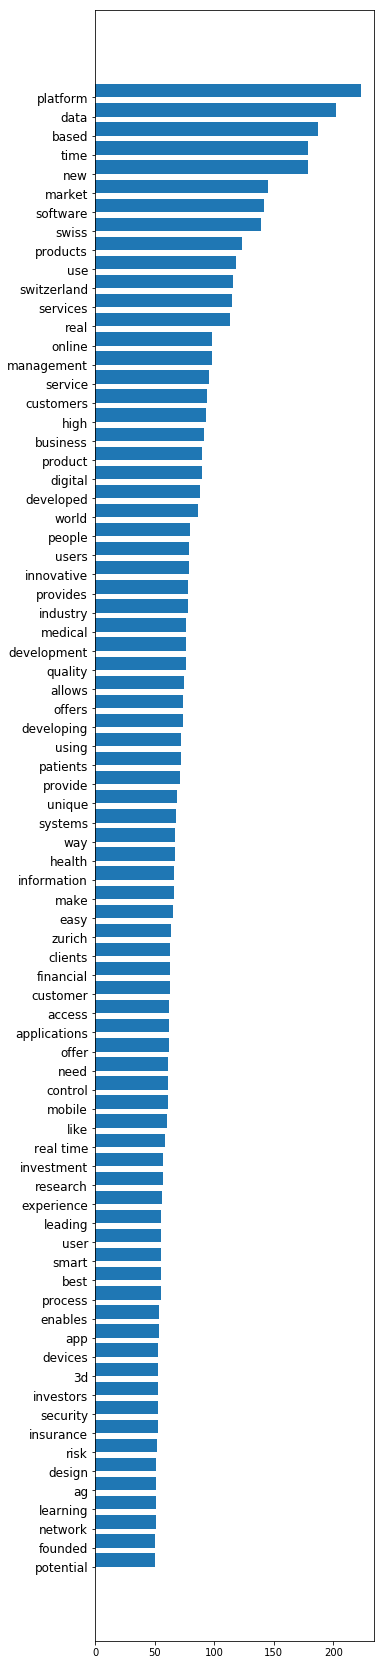

In [438]:
# Bar plot of most frequent terms
#bar?
# NOTE: plt.bar() only accepts numeric values! See the following link for adding names to the horizontal axis:
# http://people.duke.edu/~ccc14/pcfb/numpympl/MatplotlibBarPlots.html
fig = plt.figure(figsize=(5, 30))
ax = fig.add_subplot(111)
df_terms_sorted = df_terms[ind].sort_values('freq', ascending=0)

xlab = df_terms.term[ind].tolist()
xval = np.arange(sum(ind))
print(type(xval))
yval = df_terms.freq[ind]
width = 0.7
plt.barh(xval, yval, width)
#plt.bar(xval, yval, width, orientation='horizontal')

ax.set_yticks(xval + 0.5*width)
ax.invert_yaxis()
xtickNames = ax.set_yticklabels(xlab)
s = plt.setp(xtickNames, rotation=0, fontsize=12)  # Assign this to a variable, o.w. it will show a bunch of None!!

### IDF (Inverse Document Frequency) of different words

In [439]:
# Learn the IDF vector (i.e. the global term weight)
# There is one IDF value per term, which is computed as log(#documents/#documents having term t in it --one or more times)
tfidf_transformer = TfidfTransformer().fit(messages_bow)
print("Attributes and methods of tfidf_transformer")
print(dir(tfidf_transformer))

Attributes and methods of tfidf_transformer
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_get_param_names', '_idf_diag', 'fit', 'fit_transform', 'get_params', 'idf_', 'norm', 'set_params', 'smooth_idf', 'sublinear_tf', 'transform', 'use_idf']


In [440]:
#print(tfidf_transformer.idf_[bow_vectorizer_messages.vocabulary_['technology']])
print(tfidf_transformer.idf_[bow_vectorizer_messages.vocabulary_['switzerland']])
print(tfidf_transformer.idf_[bow_vectorizer_messages.vocabulary_['platform']])
print(tfidf_transformer.idf_[bow_vectorizer_messages.vocabulary_['000 people']])
print(tfidf_transformer.idf_[bow_vectorizer_messages.vocabulary_['000 rental']])

2.884034745337226
2.3893385035011185
6.390592642657207
6.796057750765372


### TF-IDF matrix

In [441]:
# Compute the TF-IDF matrix, i.e. a matrix of size (#messages, #terms) where each entry contains the tf*(idf + 1) value of each
# term appearing in the message, where:
# tf = term-frequency = "how often a term appears in a message" = (#times <term> appears in message) / (#words in message)
# idf = inverse-document-frequency = "inverse of how often a term appears in ALL messages in log scale"
# idf = log(#messages / (#messages in which <term> appears at least once))
# Ref:
# docstring of TfidfTransformer
# http://www.tfidf.com/
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)
# View the TF and TF-IDF for a couple of messages
corpus = messages['msgu']
msg = corpus.iloc[0]
analyzeMessage(msg, corpus, bow_vectorizer_messages.get_feature_names(), messages_bow, messages_tfidf)
msg = corpus.iloc[1]
analyzeMessage(msg, corpus, bow_vectorizer_messages.get_feature_names(), messages_bow, messages_tfidf)
msg = corpus.iloc[2]
analyzeMessage(msg, corpus, bow_vectorizer_messages.get_feature_names(), messages_bow, messages_tfidf)
msg = corpus.iloc[3]
analyzeMessage(msg, corpus, bow_vectorizer_messages.get_feature_names(), messages_bow, messages_tfidf)
## Note that the TF-IDF of "ya" in the last two messages is different, since TF(t) of a term t depends on the document
## where the term t appears.

(657, 76127)
0
Message:
immunos therapeutics ag is leading the next generation of immunotherapies by fast-tracking new discoveries to enhance combination therapies with novel human immunomodulatory proteins that have a role in both the innate and adaptive immune system for cancer treatment.  
Terms frequency in message:
    indterm                                term  TF     TFIDF
0      2230                            adaptive   1  0.120056
1      2233                     adaptive immune   1  0.133691
2      2234              adaptive immune cancer   1  0.133691
3      2951                                  ag   1  0.072010
4      3000                          ag leading   1  0.115666
5      3002               ag leading generation   1  0.133691
6     10215                              cancer   1  0.089404
7     10256                    cancer treatment   1  0.125715
8     13038                         combination   1  0.089404
9     13074               combination therapies   1  0.133

2
Message:
a personal health monitor in your smartphone: measure your blood pressure and other vital signs, and , with your consent, share them securely with your physician, save your historical data and statistics.  our medically-accurate, smartphone-based solution is meant to be as (or more) accurate than today's medical devices. it should receive the medical certification from both fda and ce bodies. focusing on blood pressure, which has no visible symptoms and is the #1 risk factor of early deaths, this should significantly enhance its early detection and treatment.  given the expected volume of equipped smartphones, a large db of (anonymised) measurements should be soon available for health statistics and data mining.  
Terms frequency in message:
     indterm                           term  TF     TFIDF
0       1837                       accurate   2  0.112260
1       1866            accurate smartphone   1  0.078650
2       1867      accurate smartphone based   1  0.078650
3    

In [442]:
# Add the IDF to the df_terms data frame
# Note that for same freq, the idf value needs NOT be the same because the word may appear in the same document and this
# doesn't count to the IDF.
df_terms = df_terms.sort_values('term')
df_terms['idf'] = tfidf_transformer.idf_
df_terms

,term,freq,idf
0,000,18,4.716616
1,000 000,1,6.796058
2,000 000 people,1,6.796058
3,000 association,1,6.796058
4,000 association members,1,6.796058
5,000 autonomous,1,6.796058
6,000 autonomous offs,1,6.796058
7,000 customers,1,6.796058
8,000 customers trust,1,6.796058
9,000 employees,1,6.796058


78


Text(0,0.5,'idf')

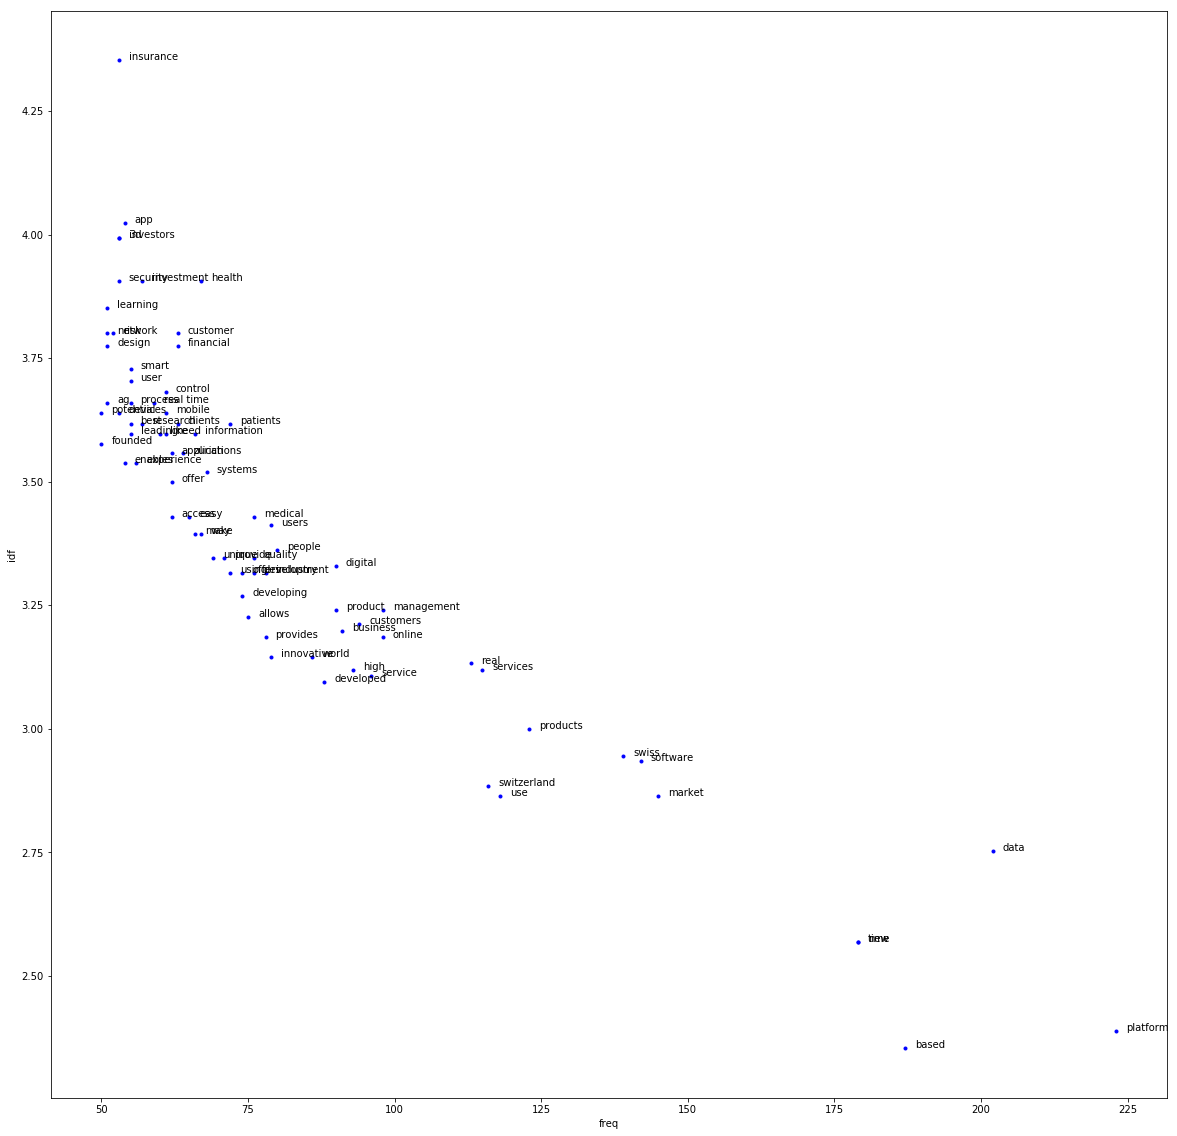

In [443]:
# Make the same distribution plot above but sorted by descending idf for words with frequency >= freq_min
print(sum(ind))
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
ax.plot(df_terms.freq[ind], df_terms.idf[ind], 'b.')
for word, x, y in zip(df_terms.term[ind], df_terms.freq[ind], df_terms.idf[ind]):
    ax.annotate(word, xy=(x,y), xytext=(10,0), textcoords='offset points', fontsize=10) #fontsize='x-small')
plt.xlabel('freq')
plt.ylabel('idf')

C:\ProgramData\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


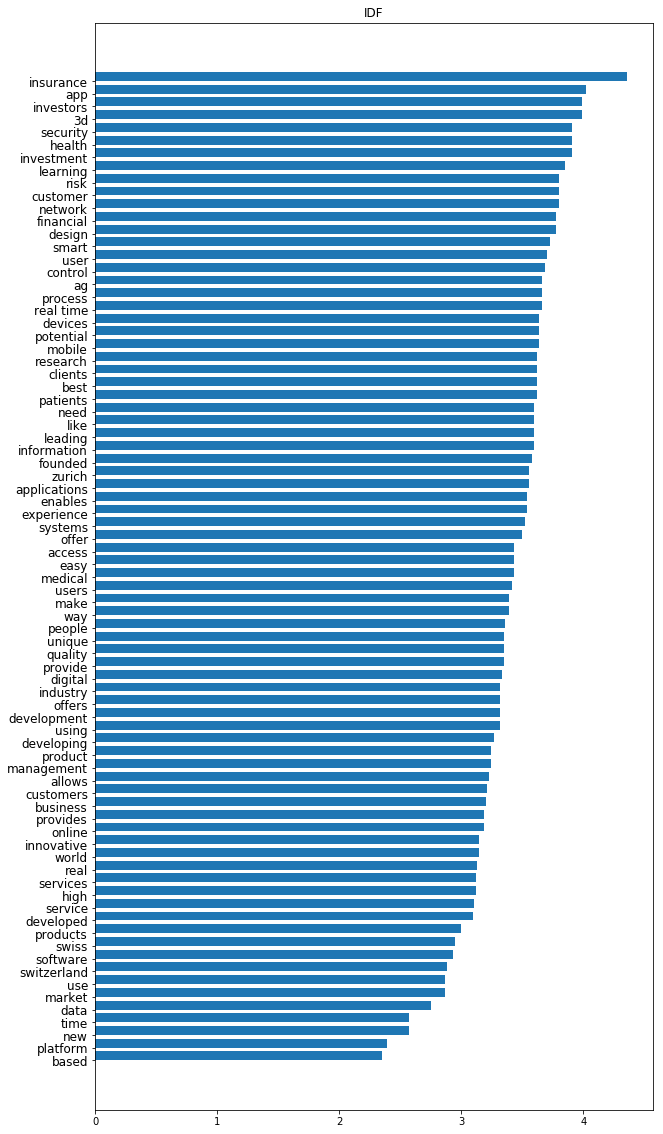

In [445]:
# Show the IDF of terms sorted by decreasing IDF
# Based on the definition of IDF (see above), the larger the IDF the smaller the frequency of the term over all the documents.
# It is used to weight the frequency of the term when computing a "more interesting" term frequency, by doing:
# "Interesting term frequency" = tf*(idf + 1)
# So, the more often a term appears in all the documents, the less weight receives when computing the
# "interesting term frequency" value.
toplot = df_terms[ind].sort_values('idf', ascending=False)
fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(111)

ylab = toplot.term.tolist()
xval = np.arange(sum(ind))
yval = toplot.idf
width = 0.7
plt.barh(xval, yval, width)
plt.title("IDF")

ax.set_yticks(xval + 0.5*width)
ax.invert_yaxis()
ytickNames = ax.set_yticklabels(ylab)
s = plt.setp(ytickNames, rotation=0, fontsize=12)

### Dimension reduction using SVD of TF-IDF matrix

In [446]:
A = messages_tfidf.T
print(type(A))
print((A))
print(A.shape)
print("(min, max) =", (np.min(abs(A)), np.max(abs(A))))

<class 'scipy.sparse.csc.csc_matrix'>
  (70575, 0)	0.08400539973469905
  (69981, 0)	0.13369122935042288
  (69980, 0)	0.13369122935042288
  (69954, 0)	0.09541151932244803
  (68682, 0)	0.13369122935042288
  (68681, 0)	0.13369122935042288
  (68658, 0)	0.09541151932244803
  (68634, 0)	0.13369122935042288
  (68633, 0)	0.13369122935042288
  (68632, 0)	0.10203056062637314
  (59147, 0)	0.13369122935042288
  (59146, 0)	0.13369122935042288
  (59143, 0)	0.12005572151804722
  (54645, 0)	0.13369122935042288
  (54644, 0)	0.13369122935042288
  (54641, 0)	0.11566606845874881
  (46181, 0)	0.13369122935042288
  (46180, 0)	0.13369122935042288
  (46151, 0)	0.07738635843077396
  (45597, 0)	0.13369122935042288
  (45596, 0)	0.13369122935042288
  (45522, 0)	0.050541465121136483
  (38498, 0)	0.13369122935042288
  (38497, 0)	0.13369122935042288
  (38457, 0)	0.07076731712684885
  :	:
  (28259, 656)	0.09623260187200415
  (26478, 656)	0.11122929152248642
  (26477, 656)	0.11122929152248642
  (26430, 656)	0.06534742

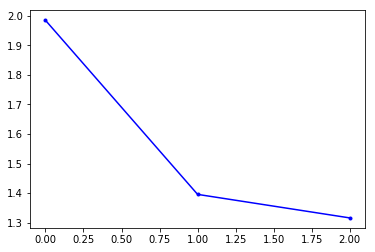

In [514]:
# SVD on a sparse matrix (using scipy.sparse.linalg.svds). If the matrix were not sparse we would use numpy.linalg.svd
sv_dim = 3
U, s, Vt = slinalg.svds(A, k=sv_dim)
srev = s[range(len(s)-1,-1,-1)]
plt.plot(srev, 'b.-')
# Check
S = np.diag(s)
Srev = np.diag(srev)
#print(np.max( np.abs( np.dot( np.dot(U, S), Vt ) - A ) ))
#print(np.max( np.abs( np.dot( np.dot(U, Srev), Vt ) - A ) ))  # This is larger than the former (say 1.25 vs. 1) when k is large

In [515]:
print(type(U))
print(U.shape)
print(s.shape)
print(Vt.shape)
print(srev)

<class 'numpy.ndarray'>
(76127, 3)
(3,)
(3, 657)
[1.98435753 1.39580964 1.31627614]


In [516]:
# Compute the projection of each document TF-IDF values on the space spanned by U.
# Note that Ak is an ndarray!! (not a matrix)
Ak = U.T*A
print(type(Ak))
Ak.shape

<class 'numpy.ndarray'>


(3, 657)

(657,)
Number of messages with 0 length: 0


(array([133., 318., 145.,  43.,   8.,   5.,   2.,   1.,   1.,   1.]),
 array([0.01514167, 0.06149997, 0.10785828, 0.15421658, 0.20057489,
        0.24693319, 0.2932915 , 0.3396498 , 0.3860081 , 0.43236641,
        0.47872471]),
 <a list of 10 Patch objects>)

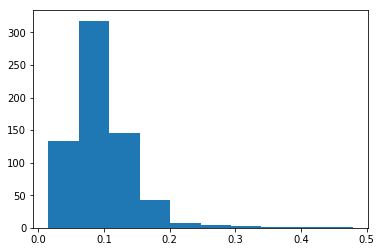

In [517]:
# Compute the norm of each document projection
# (recall that Ak is an ndarray NOT a matrix! (=> use * for elementwise multiplication))
Aknorm = np.sqrt(np.sum(Ak * Ak, axis=0))
print(Aknorm.shape)
print("Number of messages with 0 length:", sum(Aknorm==0))
plt.hist(Aknorm)

In [518]:
# Normalize the vectors so that we can compare the documents by just comparing the euclidean distances between them
Ak1 = Ak / Aknorm
Ak1.shape

(3, 657)

In [519]:
# Check (all values should be equal to 1)
Ak1norm = np.sqrt(np.sum(Ak1 * Ak1, axis=0))
Ak1norm[0:30]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [520]:
# Look at some projected document vectors
Ak1[:,:10].T

array([[-0.40174184, -0.8152741 , -0.41705112],
       [ 0.55476275, -0.27331763, -0.78583444],
       [ 0.02093192, -0.70075269, -0.71309713],
       [ 0.32459262,  0.02968463, -0.94538799],
       [-0.47387759, -0.80116008, -0.36548947],
       [ 0.41181258, -0.33541517, -0.84729397],
       [-0.38761355,  0.43650304, -0.81192416],
       [-0.3891606 , -0.77368164, -0.49997075],
       [-0.17391103, -0.70959044, -0.68281502],
       [ 0.40867269, -0.51224243, -0.75537694]])

### Clustering of projected document vectors

In [521]:
n_clusters = 4
Ak1_cluster_ward = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")   # linkage = "ward", "complete", "average"
Ak1_cluster_complete = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage="complete")   # linkage = "ward", "complete", "average"

In [522]:
Ak1_cluster_ward_fit = Ak1_cluster_ward.fit(Ak1.T)
Ak1_cluster_complete_fit = Ak1_cluster_complete.fit(Ak1.T)

In [523]:
Ak1_cluster_ward_fit.n_leaves_

657

In [550]:
# K-Means clustering
# Note:
# - KMeans uses the EM algorithm to find the clusters (see KMeans documentation)
# - The random_state parameter makes the results reproducible
from sklearn.cluster import KMeans
km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=10, random_state=1313, verbose=False)

Cluster allocation:
[2 1 2 1 2 1 3 2 2 1 2 4 1 3 1 4 4 4 1 1 4 4 4 4 1 2 3 1 2 2 1 1 1 4 2 2 1
 2 4 4 1 2 1 4 2 2 4 1 1 4 4 1 3 4 2 2 2 4 1 4 4 1 2 2 4 1 2 1 4 2 2 4 4 3
 4 4 1 1 1 2 1 4 2 4 4 4 2 2 1 4 4 4 4 4 1 4 1 4 4 4 4 1 3 4 2 1 4 4 4 4 2
 3 1 2 1 3 1 4 1 4 4 2 1 4 1 4 4 4 4 4 1 3 2 2 4 2 4 4 4 4 2 2 4 2 4 4 1 1
 1 4 2 4 2 2 2 1 1 1 4 1 4 1 1 1 4 4 4 4 3 4 2 4 1 4 1 1 1 4 2 4 1 4 2 1 1
 4 2 1 1 3 4 4 1 4 3 1 1 4 4 4 4 4 4 4 1 1 1 3 2 1 4 3 2 4 2 3 2 1 4 2 1 3
 4 2 1 2 2 1 2 1 1 2 4 2 4 4 1 1 2 4 4 4 1 1 1 4 4 1 4 2 4 2 4 4 4 1 4 3 1
 1 4 1 4 1 3 1 4 4 4 4 2 1 4 3 1 4 1 1 1 2 1 2 2 4 2 3 2 1 1 3 2 2 4 4 1 4
 4 1 4 3 1 4 4 4 4 4 1 4 1 1 4 4 1 1 3 1 4 2 4 1 3 1 1 1 4 2 4 1 4 1 4 4 4
 1 3 1 4 2 4 4 1 4 3 4 3 4 2 1 1 1 4 2 2 4 1 2 4 4 1 1 3 2 1 4 1 1 4 4 3 1
 3 4 4 4 4 3 1 1 4 1 3 4 3 3 3 3 4 2 2 4 1 4 4 4 2 1 4 1 2 2 4 1 2 1 1 4 2
 1 4 1 3 2 1 4 1 1 3 2 4 2 2 2 3 2 1 4 1 3 1 2 1 3 3 4 3 4 4 1 2 1 2 1 1 2
 1 3 4 4 3 3 4 4 3 3 3 4 3 4 4 1 4 4 4 2 1 4 2 1 4 4 1 2 4 2 4 4 4 4 4 1 2
 4 4 

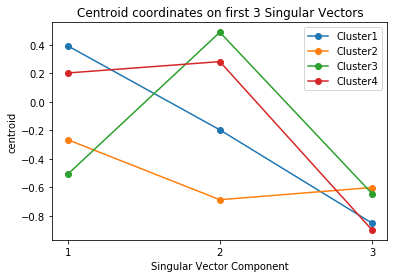

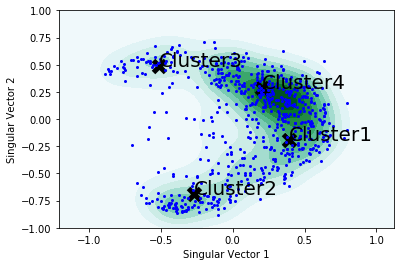

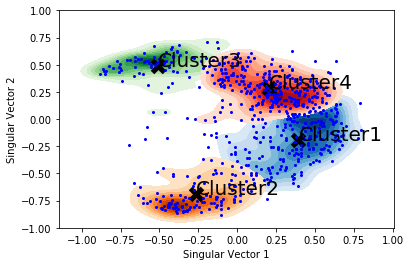

In [551]:
# Plot the clusters
def plotClustersSVSpace(km_cluster_fit, SV, components=(1,2)):
    """
    km_cluster_fit: result of KMeans.fit() on the training data.
    SV: Singular Vector matrix (projection of the original matrix into the selected SV-reduced space)
    components: Singular Vector components to plot (the principal component is 1)
    """
    center1 = km_cluster_fit.cluster_centers_[:,components[0]-1]
    center2 = km_cluster_fit.cluster_centers_[:,components[1]-1]
    plt.plot(center1, center2, 'kx', markersize=12, markeredgewidth=5)
    plt.plot(SV[components[0]-1,:], SV[components[1]-1,:], 'b.', markersize=4)
    for c in range(n_clusters):
        plt.text(center1[c], center2[c], "Cluster" + str(c+1), color='black', fontsize=20)
    plt.xlabel("Singular Vector %s" %(components[0]))
    plt.ylabel("Singular Vector %s" %(components[1]))

### Plot the singular vector coordinates by cluster
km_cluster_fit = km.fit(Ak1.T)
print("Cluster allocation:")
print(km_cluster_fit.labels_ + 1)
print("Cluster centroids in SVD-reduced space:")
print(km_cluster_fit.cluster_centers_)
plt.figure()
plt.gca().set_xticks(np.array(range(sv_dim))+1)
for c in range(n_clusters):
    plt.plot(np.array(range(sv_dim))+1, km_cluster_fit.cluster_centers_[c, :], '.-', markersize=12)
plt.title("Centroid coordinates on first 3 Singular Vectors")
plt.xlabel("Singular Vector Component")
plt.ylabel("centroid")
legend = ("Cluster" + " Cluster".join(map(str, np.array(range(n_clusters))+1))).split()
plt.legend(legend, loc="best")
plt.savefig(resultsdir + "KMeansClusters-SVSpace-CentroidCoordinatesByCluster.jpg", format="jpg")

### Plot on the Singular Vectors space
svs = (1,2)  # Which SV components to plot

# Overall Density plot
plt.figure()
plt.ylim((-1,1))
sns.kdeplot(Ak1[svs[0]-1,:], Ak1[svs[1]-1,:], shade=True)
plotClustersSVSpace(km_cluster_fit, Ak1, components=svs)
plt.savefig(resultsdir + "KMeansClusters-SVSpace-DensityOverall&Centroids.jpg", format="jpg")

# Density plot by cluster
plt.figure()
plt.ylim((-1,1))
colors = ["Blues", "Oranges", "Greens", "Reds", "Purples"]
for c in range(n_clusters):
    ind = km_cluster_fit.labels_ == c
    sns.kdeplot(Ak1[svs[0]-1,ind], Ak1[svs[1]-1,ind], cmap=colors[c], shade=True, shade_lowest=False)
        ## The shade_lowest=False is very important in order to avoid overriding of 2D densities of different colors
        ## Ref: example on iris dataset in kdeplot documentation
plotClustersSVSpace(km_cluster_fit, Ak1, components=svs)
plt.savefig(resultsdir + "KMeansClusters-SVSpace-DensityByCluster&Centroids.jpg", format="jpg")

In [552]:
# Compare the three clustering algorithms in terms of labels
np.c_[Ak1_cluster_ward_fit.labels_, Ak1_cluster_complete_fit.labels_, km_cluster_fit.labels_]

array([[1, 2, 1],
       [2, 1, 0],
       [1, 3, 1],
       ...,
       [2, 3, 0],
       [0, 0, 3],
       [0, 1, 3]], dtype=int64)

In [553]:
# Add the cluster labels to the messages data frame
#messages['cluster'] = Ak1_cluster_ward_fit.labels_
messages['cluster'] = Ak1_cluster_complete_fit.labels_
messages['cluster_km'] = km_cluster_fit.labels_

In [554]:
messages[:20]

,msg,len,nwords,wordlen,msgu,cluster,cluster_km
0,b'ImmunOs Therapeutics AG is leading the next ...,269,38,7.078947,immunos therapeutics ag is leading the next ge...,2,1
1,"b""We have developed an ultra-small portable ca...",598,95,6.294737,we have developed an ultra-small portable card...,1,0
2,"b""A personal health monitor in your smartphone...",723,110,6.572727,a personal health monitor in your smartphone: ...,3,1
3,b'The Company FairTrace is a Swiss company ...,1962,289,6.788927,the company fairtrace is a swiss company es...,3,0
4,b'Cellestia focuses on small molecules capable...,1189,168,7.077381,cellestia focuses on small molecules capable o...,2,1
5,b'The company is a spin-off company of the Aut...,244,38,6.421053,the company is a spin-off company of the auton...,1,0
6,b'Allthings transforms buildings into digital ...,912,136,6.705882,allthings transforms buildings into digital pr...,0,2
7,"b""Polyphor is a clinical stage, privately held...",893,130,6.869231,"polyphor is a clinical stage, privately held s...",2,1
8,b'Tecuro has developed a novel medical device ...,1553,231,6.722944,tecuro has developed a novel medical device cl...,2,1
9,b'Our membranes and dialysis systems help you ...,652,92,7.086957,our membranes and dialysis systems help you pu...,3,0


In [555]:
# Look at the clusters by sorting the most used terms in each cluster
freq_min2plot = 1
topn = 10
clustervar = 'cluster_km'

# Frequency of each term in each cluster
dtfmatrix = messages_bow
terms = bow_vectorizer_messages.get_feature_names()

for c in range(n_clusters):
    # Find the documents belonging to the current cluster
    indmessage = np.where(messages[clustervar]==c)[0]    # [0] because np.where() returns a tuple! and here I want the rows)
    print("Current cluster %d has %d messages" %(c+1, len(indmessage)))
    #dtf = dtfmatrix.todense()[indmessage,:]
    #print(dtf.shape)
    # Compute the term frequency in the messages belonging to the cluster (based on the Document-Term frequency matrix messages_bow)
    terms_freq = np.squeeze( np.asarray( np.sum(dtfmatrix[indmessage,:], 0) ))
    #print(terms_freq)
    # Filter to the terms having at least freq_min2plot occurrences
    terms_c = np.array(terms)[terms_freq>=freq_min2plot]
    terms_freq = terms_freq[terms_freq>=freq_min2plot]
    order = np.argsort(terms_freq)[::-1]
    terms_c = terms_c[order]
    terms_freq = terms_freq[order]
    #print type(terms_c), type(terms_freq)
    print(pd.DataFrame({'term': terms_c[0:topn], 'freq': terms_freq[0:topn]}))
    #print len(terms_c), len(terms_freq[terms_freq>0])


Current cluster 1 has 203 messages
   freq       term
0    77       data
1    69   software
2    56        new
3    53      based
4    51       high
5    51   products
6    46  developed
7    42    product
8    42       time
9    41        use
Current cluster 2 has 119 messages
   freq         term
0    66     patients
1    60      medical
2    56          new
3    49        based
4    41         drug
5    39   developing
6    39       health
7    37     clinical
8    36  development
9    33     platform
Current cluster 3 has 77 messages
   freq         term
0    49   investment
1    48    investors
2    44     platform
3    40   management
4    34        swiss
5    33       market
6    32    financial
7    32         real
8    26       estate
9    26  real estate
Current cluster 4 has 258 messages
   freq         term
0   118     platform
1   104         data
2   104         time
3    80     services
4    69       market
5    69     business
6    68       online
7    65        based
8

_Based on the above clustering words, the clusters could be named as follows:_  
- Cluster 1: Data Analytics  
- Cluster 2: Medical  
- Cluster 3: Finance  
- Cluster 4: Service Platforms  

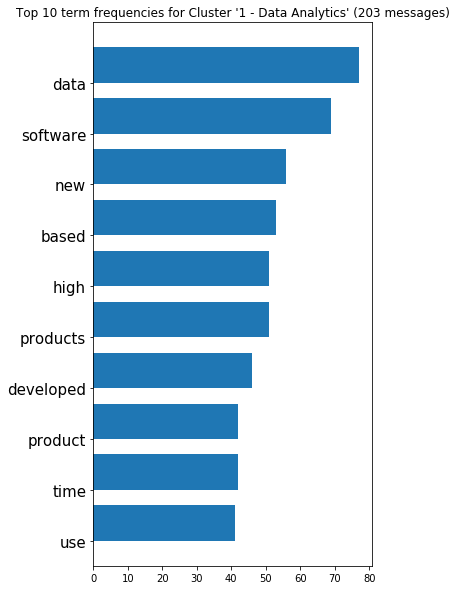

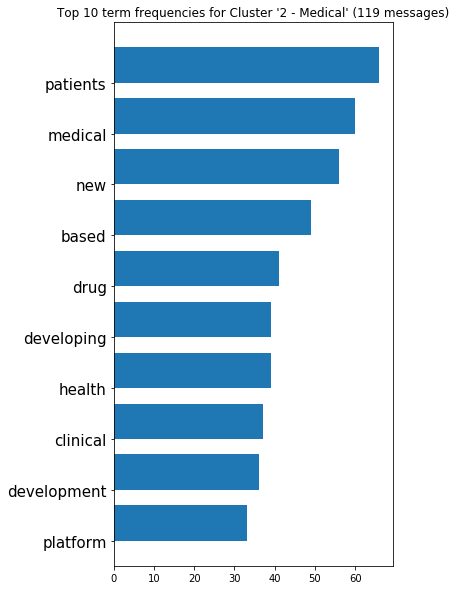

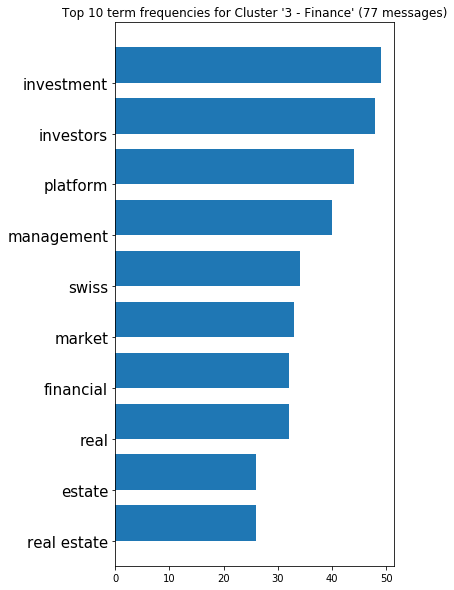

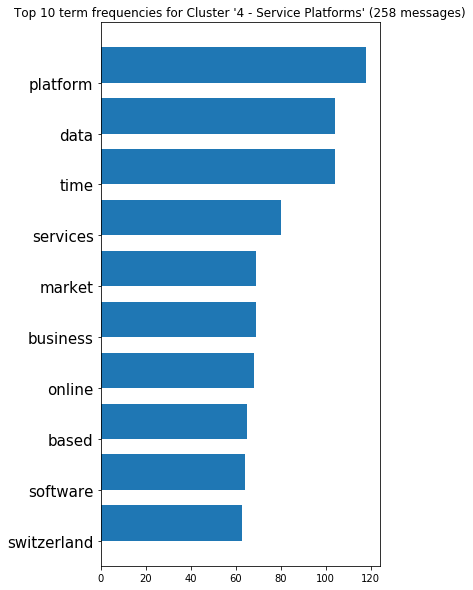

In [556]:
# Define the labels to assign to each cluster where the cluster number is the cluster index
cluster_labels = ["1 - Data Analytics", "2 - Medical", "3 - Finance", "4 - Service Platforms"]

for c in range(n_clusters):
    indmessage = np.where(messages[clustervar]==c)[0]    # [0] because np.where() returns a tuple! and here I want the rows)
    # Compute the term frequency in the messages belonging to the cluster (based on the Document-Term frequency matrix messages_bow)
    terms_freq = np.squeeze( np.asarray( np.sum(dtfmatrix[indmessage,:], 0) ))
    # Filter to the terms having at least freq_min2plot occurrences
    terms_c = np.array(terms)[terms_freq>=freq_min2plot]
    terms_freq = terms_freq[terms_freq>=freq_min2plot]
    order = np.argsort(terms_freq)[::-1]
    terms_c = terms_c[order]
    terms_freq = terms_freq[order]
    plotFrequencies(terms_c[0:topn], terms_freq[0:topn], 'b',
                    title="Top %d term frequencies for Cluster '%s' (%d messages)" %(topn, cluster_labels[c], len(indmessage)),
                    fontsize=15, figsize=(5,10),
                    savefile=resultsdir + "KMeansClusters-ClustersTopTerms-Cluster%s.jpg" %(c+1), saveformat="jpg")

### Biplot

In [557]:
corpus = messages['msgu']
allterms = bow_vectorizer_messages.get_feature_names()
tfidfmatrix = messages_tfidf
eigenleft = U
eigenvalues = s
eigenright = Vt  # already transposed eigenvectors
pcs = [1,2]

In [558]:
# Documents in the different clusters
print("Cluster 1")
messages0 = messages['msgu'][messages[clustervar]==0]
print(messages0)
print("Cluster 2")
messages1 = messages['msgu'][messages[clustervar]==1]
print(messages1)
print("Cluster 3")
messages2 = messages['msgu'][messages[clustervar]==2]
print(messages2)
print("Cluster 4")
messages3 = messages['msgu'][messages[clustervar]==3]
print(messages3)
print("Cluster 5")
messages4 = messages['msgu'][messages[clustervar]==4]
print(messages4)
print("Cluster 6")
messages5 = messages['msgu'][messages[clustervar]==5]
print(messages5)

Cluster 1
1      we have developed an ultra-small portable card...
3      the company    fairtrace is a swiss company es...
5      the company is a spin-off company of the auton...
9      our membranes and dialysis systems help you pu...
12     oviva is a leading provider of technology-enab...
14     urban games is an independent video game devel...
18     cyberhaven is the only security company that p...
19     dolfinos provides rest-systems for violin and ...
24     it is only a matter of time before humanity re...
27     nexthink develops and commercializes innovativ...
30     natural gas quality is varying more through an...
31     scrona is all about changing paradigms in micr...
32     rqmicro's solution detects dangerous bacteria ...
36     weve created inofea from the desire to meet a ...
40     the sensoryx system consists of a variable num...
42     pxl vision ag (pxl) is a swiss high-tech compa...
47     eaternity provides comprehensive solutions (so...
48     from a project

0    the company    fairtrace is a swiss company es...
1    newgreentec develops and offers an automated c...
dtype: object
Messages to plot:
0    the company    fairtrace is a swiss company es...
1    newgreentec develops and offers an automated c...
dtype: object
Terms to plot:
['buildings', 'digital', 'range', 'guestready']
indmessages:
[3, 15]
Shape of the TF-IDF matrix restricted to the documents to analyze
(76127, 2)
Shape of the TF-IDF matrix restricted to the terms to analyze
(4, 657)
Shape of the projected Document matrix
(3, 2)
Shape of the Term matrix
(3, 4)
Plotting biplot on PCs 1 and 2
Point 0 : (-0.042739371279168006, 0.028784520039809237)
Point 1 : (-0.15330542084275495, 0.07042750958941557)
Point 2 : (-0.05205752610918487, 0.008533923870498722)
Point 3 : (-0.006877739635155485, 0.011947500983369993)
Document j = 0
Arrow 0 : (-0.24700359527530807, 0.0054554574444544025)
Document j = 1
Arrow 1 : (-0.11869407226871662, 0.019905992835755885)


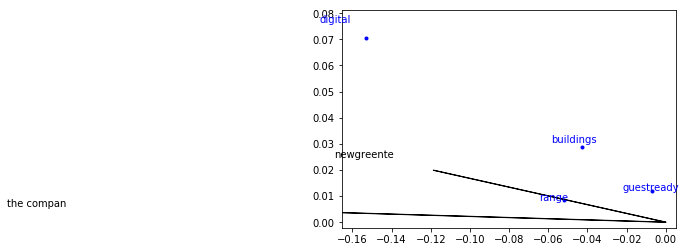

In [559]:
#documents = corpus.iloc[[0, 3, 5, 15, 23, 28, 37, 50]]
documents = pd.Series(np.r_[messages0.iloc[[1]].tolist(), messages3.iloc[[1]].tolist()])
print(documents)
#terms = ['technology', 'insurance', 'solution']
terms = ['buildings', 'digital', 'range', 'guestready']
showBiplot(documents, terms, corpus, allterms, tfidfmatrix, eigenleft, eigenvalues, eigenright, pcs=pcs)

### Cluster new messages

In [560]:
# Ref: http://blog.christianperone.com/?p=1589
#message_new = "Today more than 1,8 billion people have no access to clean drinking water. 2025 it will be one third of mankind after WHO report, 2014. At the same time the atmosphere is a huge inexhaustible and sustainable water source.\r\nAquAero develops energy efficient air wells which extract large amounts of drinking water from the air even in a desert to an affordable prize. The air well is designed for humanitarian aid to provide 1'000 - 2'000 people a day with drinking water or can be used for industrial activities also.\r\n"
msg = ["Today less than asdfadf 12345 billion people have access to internet and clean water. What technology can do now? Test for health.", "health medical"]     
msg = [unicodedata.normalize('NFD', m) for m in msg]
print(msg)
# Compute the document-term frequency matrix for the message based on the learned vocabulary (n-grams)
msg_bow = bow_vectorizer_messages.transform(msg)
msg_tfidf = tfidf_transformer.transform(msg_bow)
print(msg_tfidf.shape)
print(msg_tfidf)
print(msg_bow)
print(msg_bow.shape)
corpus_new = pd.DataFrame({'msg': msg})
analyzeMessage(msg, corpus_new, bow_vectorizer_messages.get_feature_names(), msg_bow, msg_tfidf)

['Today less than asdfadf 12345 billion people have access to internet and clean water. What technology can do now? Test for health.', 'health medical']
(2, 76127)
  (0, 74271)	0.30379702726489627
  (0, 69493)	0.2258311525742674
  (0, 68400)	0.29227711285428687
  (0, 49611)	0.39014168679722405
  (0, 49608)	0.1930065814860549
  (0, 36238)	0.24514703404114438
  (0, 31117)	0.2242139453842452
  (0, 12075)	0.32707358656089736
  (0, 8225)	0.39014168679722405
  (0, 8223)	0.32707358656089736
  (0, 8197)	0.25795704900869587
  (0, 1559)	0.19683513714228176
  (1, 42418)	0.4007653070931568
  (1, 31183)	0.7943462492985217
  (1, 31117)	0.4565098080610083
  (0, 1559)	1
  (0, 8197)	1
  (0, 8223)	1
  (0, 8225)	1
  (0, 12075)	1
  (0, 31117)	1
  (0, 36238)	1
  (0, 49608)	1
  (0, 49611)	1
  (0, 68400)	1
  (0, 69493)	1
  (0, 74271)	1
  (1, 31117)	1
  (1, 31183)	1
  (1, 42418)	1
(2, 76127)
0
Message:
['Today less than asdfadf 12345 billion people have access to internet and clean water. What technology can 

In [561]:
# Project
A_new = msg_tfidf.T
Ak_new = U.T*A_new
Ak_new_norm = np.sqrt(np.sum(Ak_new * Ak_new, axis=0))
Ak1_new = Ak_new / Ak_new_norm
print(Ak1_new)

[[ 0.1907088  -0.22738417]
 [-0.25466518 -0.83934959]
 [-0.94803787 -0.49374963]]


In [562]:
# Cluster
print(km_cluster_fit.transform(Ak1_new.T))
print(km_cluster_fit.predict(Ak1_new.T))

[[0.23178542 0.71823763 1.0654046  0.53942827]
 [0.96282237 0.19029845 1.36613431 1.26825132]]
[0 1]


In [568]:
pickle.dump(dict({'bow_vectorizer': bow_vectorizer_messages,
                 'tfidf_transformer': tfidf_transformer,
                 'U': U,
                 'cluster_model': km_cluster_fit,
                 'cluster_labels': cluster_labels}),
            open(resultsdir + "daniel_startupch_description_based_clustering_model.pkl", "wb"))

In [569]:
def description_cluster(messages_list_or_array, pickle_file_with_model):
    
    model = pickle.load(open(pickle_file_with_model, "rb"))
    print("Model details:")
    print(model)
    
    bow_vectorizer = model['bow_vectorizer']
    tfidf_transformer = model['tfidf_transformer']
    U = model['U']
    cluster_model = model['cluster_model']                   # This should be a K-means cluster model
    cluster_labels = model['cluster_labels']

    # 0) Normalize messages
    msg = [unicodedata.normalize('NFD', m) for m in messages_list_or_array]

    # 1) Compute the document-term frequency matrix for the message based on the learned vocabulary (n-grams)
    msg_bow = bow_vectorizer.transform(msg)

    # 2) Compute the TF-IDF matrix (used for projection)
    msg_tfidf = tfidf_transformer.transform(msg_bow)
    
    # 3) Project into SVD-reduced space and normalize
    A_new = msg_tfidf.T
    Ak_new = U.T*A_new
    Ak_new_norm = np.sqrt(np.sum(Ak_new * Ak_new, axis=0))
    Ak1_new = Ak_new / Ak_new_norm
    
    # 4) Cluster
    return([cluster_labels[c] for c in cluster_model.predict(Ak1_new.T)])
    

In [570]:
msg = ["Today less than asdfadf 12345 billion people have access to internet and clean water. What technology can do now? Test for health.",
       "health medical"]     
msg = [unicodedata.normalize('NFD', m) for m in msg]
print(msg)
description_cluster(np.array(msg), resultsdir + "daniel_startupch_description_based_clustering_model.pkl")

['Today less than asdfadf 12345 billion people have access to internet and clean water. What technology can do now? Test for health.', 'health medical']
Model details:
{'bow_vectorizer': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None,
        stop_words=frozenset({'than', 'since', 'least', 'the', 'less', 'anyhow', 'nine', 'he', 'my', 'becomes', 'become', 'is', 'after', 'never', 'these', 'beforehand', 'whence', 'who', 'whereas', 'whole', 'everywhere', 'thick', 'mill', 'here', 'fifteen', 'amoungst', 'front', 'there', 'what', 'everyone', 'a...e', 'within', 'eleven', 'few', 'latter', 'will', 'when', 'beyond', 'interest', 'however', 'system'}),
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None), 'tfidf_transformer': TfidfTransformer(nor

['1 - Data Analytics', '2 - Medical']

In [571]:
import sys
sys.version

'3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]'